# Optical Characterization of Silicon: Swanepoel Method enhaced with Machine Learning

Explanation

## 1) Libraries

Explanation

In [1]:
# Basic libraries
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Information on autoreload: https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [3]:
# We import the functions from our package
from src.models import * 
from src.generating import * 

import src.learning_NN as learning_NN
import src.general as general

## 2) Generating multiple spectra

Explanation

In [45]:
# PARAMETERS

# Wavelength range
wv = torch.arange(800, 2100, 4) 

# Ideal transmission of a transparent substrate
Ts = torch.ones(len(wv))*0.92

# Models for refractive index n and extinction coefficient k 
model_n = 'Wemple-DiDomenico'
model_k = 'Urbach'

In [46]:
# GENERATING DATASET
generate = generating(wavelength = wv, T_substrate = Ts, \
    model_n = model_n, model_k = model_k)

# Input: Transmission spectrum {T(lambda)} = {0.1, 0.15, 0.2, 0.1, ...}
# Output: Envelope of the spectrum {T_max(lambda)} = {0.6, 0.61, 0.62, 0.65, ...}
input, output = generate.spectra(n_samples = 10000)


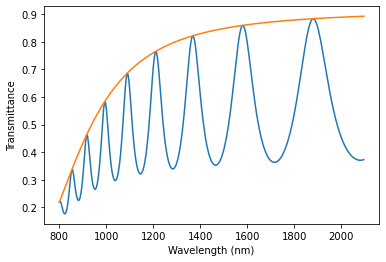

In [47]:
# VISUALIZING ONE SPECTRUM
plt.plot(wv, input[0])
plt.plot(wv, output[0])
plt.xlabel('Wavelength (nm)')
plt.ylabel('Transmittance')
plt.savefig('output/example_TM.png',bbox_inches='tight', pad_inches=0)
plt.show()

## 3) Learning the transmission

Explanation

In [100]:
# Some specific libraries
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [106]:
# Hyper-parameters 
input_size = input.shape[1]
hidden_size = 100 
num_out = input.shape[1]
num_epochs = 2
batch_size = 100
learning_rate = 0.5

In [103]:
# Dataset class
class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, X, y):
        'Initialization'
        self.X = X
        self.y = y

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.X)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        X = self.X[index]
        y = self.y[index]

        return X, y
        
# Split dataset for training and test
input_train, input_test, output_train, output_test = \
    train_test_split(input, output, test_size=0.2, random_state=len(input))

# Create dataset
dataset_train = Dataset(input_train, output_train)
dataset_test = Dataset(input_test, output_test)

# Visualize data from training dataset
first_data = dataset_train[0]
a, b = first_data
print(f'The input transmission of size {a.shape} is {a[0:3]}...')
print(f'The output envelope of size {b.shape} is {b[0:3]}...')

# Batchsize for data


The input transmission of size torch.Size([325]) is tensor([0.1158, 0.1219, 0.1293])...
The output envelope of size torch.Size([325]) is tensor([0.1307, 0.1377, 0.1449])...


In [ ]:
# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.input_size = input_size
        self.l1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_out)  
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        out = self.sigmoid(out)
        # no activation and no softmax at the end
        return out

model = NeuralNet(input_size, hidden_size, num_out).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

In [55]:
# Training the model
n_total_steps = len(X_train)

for epoch in range(num_epochs):
    for i, (X, y) in enumerate(train_generator):  

        X = X.to(device)
        y = y.to(device)
        
        # Forward pass
        y_predicted = model(X)
        loss = criterion(y_predicted, y)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #if (i+1) % 5 == 0:
        print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')


Epoch [1/2], Step [1/8000], Loss: 1396.5288
Epoch [2/2], Step [1/8000], Loss: 1396.5288


## 4) Trying with a real spectrum

### 4.1. Download the real spectrum

output/Original_Vs_NIR_spectrum_1.png


0

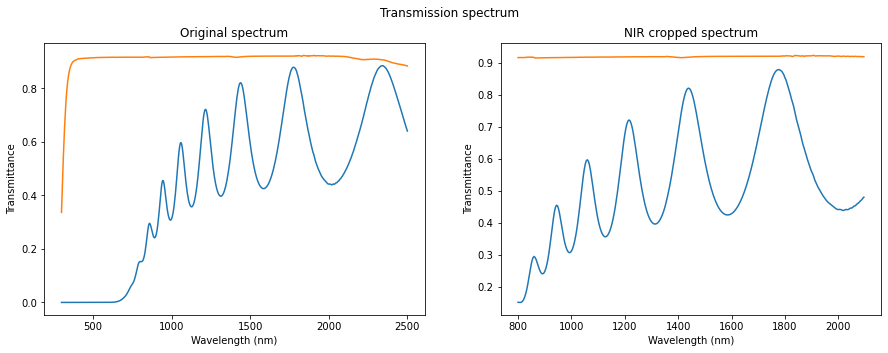

In [9]:
# Names of the TXT files with the sample transmittance data and the substrate alone
type_sample = 'real'    # Either 'real' or 'simulated' spectra  
sample = 1              # For the 'real' spectra, there are 1 to 14 samples

name_Sample = 'spectrum_'+str(sample)
name_Substrate= 'Substrate_'+str(sample)


# We obtain the wavelength (wv), the sample transmission (T), and the substrate alone 
# transmisison (Ts) as torch tensors. We plot the original spectrum and the spectrum cropped to
# the NIR region and we save the plot in the output folder.
wv, T, Ts = general.load_spectra(type_sample = type_sample, name_Sample = name_Sample, \
    name_Substrate = name_Substrate)

figtitle = 'Original_Vs_NIR_' + name_Sample
general.save_fig_as_png(figtitle)

### 4.2. Applying our model

In [7]:
predicted_output = learning_NN.hola(input, output)
predicted_output.shape